# Simpsons Classifier

## Подготовка рабочей среды.

*   Установить билиотеки
*   Подключить GPU
*   разархивировать датасет (и прописать пути)



In [ ]:
#!pip install -U torch torchvision

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
#!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
from google.colab import drive
drive.mount('/content/drive/')
WORK_DIR = "/MyDrive/Colab_Notebooks/Deep_Learning_2022/Seminars/L6-Simpsons"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!unzip -q /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_2022/Seminars/L6-Simpsons/data/journey-springfield.zip -d springfield

replace springfield/characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Nov  8 14:20:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

## Подготовка данных.

*   Расписать класс SimpsonDataset для работы с данными.
*   train-test split
*   Transpose



In [10]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
      super().__init__()
      self.files = sorted(files)
      self.mode = mode

      if self.mode not in DATA_MODES:
        print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
        raise NameError
      
      self.len_ = len(self.files)
      self.label_encoder = LabelEncoder()

      if self.mode != "test":
        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump_file:
          pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
      
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
TRAIN_DIR = Path('/content/springfield/train/simpsons_dataset')
TEST_DIR = Path('/content/springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

## Отрисовка изображений

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

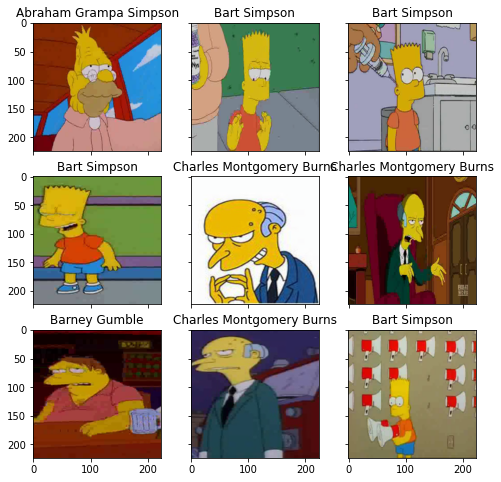

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), 
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), 
          title=img_label,plt_ax=fig_x)

## Модели

*   Написать простую нейросеть
*   Взять готовую и применить трансфер-лёрнинг
*   Метрики, оценка качества с визуализацией

*Описание слоев:*

* размерность входа: 3x224x224
* размерности после слоя: 8x111x111
* 16x54x54
* 32x26x26
* 64x12x12
* выход: 96x5x5

In [15]:
class SimpleCNN(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv2 = nn.Sequential(
        #nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv3 = nn.Sequential(
        nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv4 = nn.Sequential(
        #nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv5 = nn.Sequential(
        #nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
        )
    self.out = nn.Linear(96 * 5 * 5, n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    
    x = x.view(x.size(0), -1)
    logits = self.out(x)
    return logits


**fit_epoch**  - Обучение модели по эпохам. На вход функции подаются модель, даталоадер, оптимизатор и функция лосса. Функция возвращает лосс и точность после пробега эпохи обучения.

In [16]:
# Обучение модели в рамках одной эпохи. Через даталоадер загружаем батчи, прогоняем forward-backward, возвращаем лосс и аккурэси
def fit_epoch(model, train_loader, optimizer, criterion):
  run_correct = 0 # Количество верных предсказаний, для подсчета лосса
  run_loss = 0 # куммулятивный лосс
  processed_data = 0 # общее число обработанных сэмплов, для подсчета лосса.(Напрямую из лоадера не вытащить?)
  model.train()
  for inputs, labels in train_loader:
    '''
    1. Перекинуть input, label на device.
    2. Обнулить градиент оптимизатора.
    3. Сделать предсказание.
    4. Подсчитать лосс
    5. backward-pass (вызывается в лоссе?)
    6. шаг оптимизатора
    7. Рассчитываем точность и лосс
    '''
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()

    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(output, 1)
    run_loss += loss.item() * inputs.size(0)
    run_correct += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = run_loss / processed_data
  train_acc = run_correct.cpu().numpy() / processed_data
  return train_loss, train_acc


На валидационной выборке обучение не идет, в остальном то же самое.

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size # double()
    return val_loss, val_acc


In [18]:
#
def train(train_files, val_files, model, epochs, batch_size):
  train_loader = DataLoader(train_files, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(val_files, batch_size = batch_size, shuffle = False)

  history = []
  log_template = "\nEpoch: {ep:03d} train_loss: {t_loss:0.4f} train_accuracy: {t_acc:0.4f}\
  val_loss: {v_loss:0.4f} val_accuracy: {v_acc:0.4f}"

  with tqdm(desc = "epoch", total = epochs) as pbar_outer:
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, opt, criterion)
      print("loss", train_loss)
            
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))
          
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                     v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
      
  return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCNN(n_classes).to(DEVICE)
print("we will classify :{} classes".format(n_classes))


we will classify :42 classes


In [20]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

history = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=64)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 2.337648685665387


epoch:  25%|██▌       | 1/4 [02:40<08:00, 160.07s/it]


Epoch: 001 train_loss: 2.3376 train_accuracy: 0.3575  val_loss: 1.7707 val_accuracy: 0.5178
loss 1.5113489303598586


epoch:  50%|█████     | 2/4 [05:10<05:09, 154.55s/it]


Epoch: 002 train_loss: 1.5113 train_accuracy: 0.5865  val_loss: 1.3794 val_accuracy: 0.6339
loss 1.1288202788026571


epoch:  75%|███████▌  | 3/4 [07:40<02:32, 152.14s/it]


Epoch: 003 train_loss: 1.1288 train_accuracy: 0.6901  val_loss: 1.1443 val_accuracy: 0.6974
loss 0.8654502014937967


epoch: 100%|██████████| 4/4 [10:07<00:00, 151.92s/it]


Epoch: 004 train_loss: 0.8655 train_accuracy: 0.7601  val_loss: 1.0018 val_accuracy: 0.7356


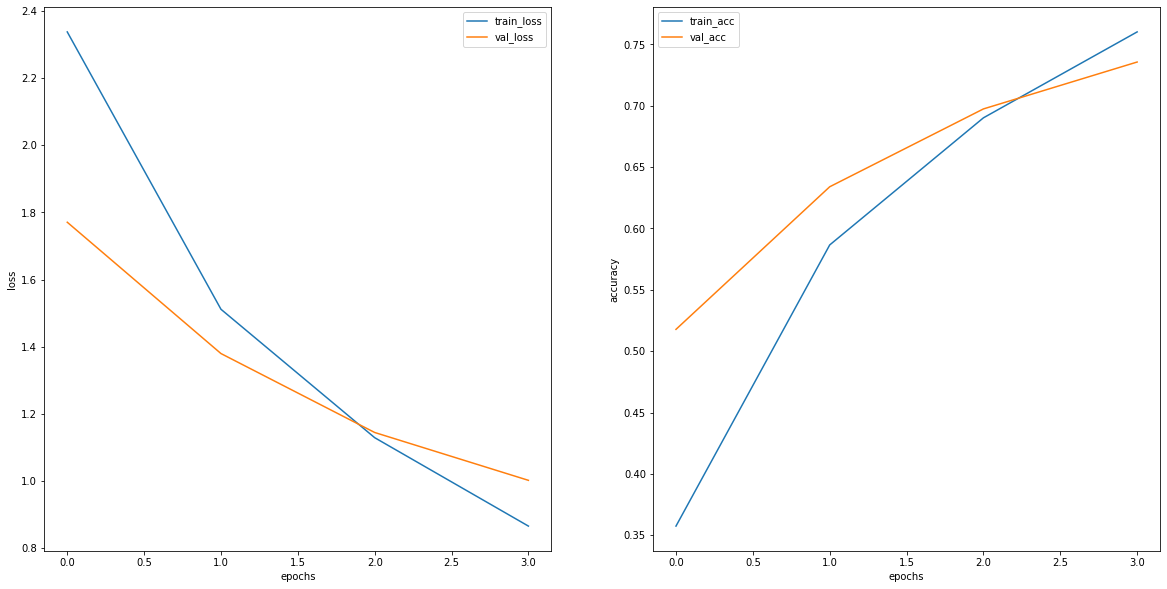

In [24]:
def visualize_loss_acc(history):
  loss, acc, val_loss, val_acc = zip(*history)
  fig, ax = plt.subplots(1, 2, figsize = (20,10))
  
  ax[0].plot(loss, label="train_loss")
  ax[0].plot(val_loss, label="val_loss")
  ax[0].legend(loc='best')
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("loss")

  ax[1].plot(acc, label="train_acc")
  val_accuracy = [i.item() for i in val_acc]
  ax[1].plot(val_accuracy, label="val_acc")
  ax[1].legend(loc='best')
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("accuracy")
  plt.show()

visualize_loss_acc(history)

## ToDo list

1. Отбалансировать классы, если надо.
2. Аугментировать датасет через transforms.
3. Попробовать другие сетки
4. Transfer Learning.
5. Ансамбли.

In [22]:
simple_cnn_02 = SimpleCNN(n_classes).to(DEVICE)

history = train(train_dataset, val_dataset, model=simple_cnn_02, epochs=6, batch_size=64)
visualize_loss_acc(history) # 2 Batchnorm at random layers

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 2.4322660347634617


epoch:  17%|█▋        | 1/6 [02:28<12:22, 148.60s/it]


Epoch: 001 train_loss: 2.4323 train_accuracy: 0.3338  val_loss: 1.9200 val_accuracy: 0.4742
loss 1.6029494662931507


epoch:  33%|███▎      | 2/6 [04:58<09:58, 149.63s/it]


Epoch: 002 train_loss: 1.6029 train_accuracy: 0.5618  val_loss: 1.4525 val_accuracy: 0.6009
loss 1.182534438347739


epoch:  50%|█████     | 3/6 [07:30<07:31, 150.50s/it]


Epoch: 003 train_loss: 1.1825 train_accuracy: 0.6717  val_loss: 1.2000 val_accuracy: 0.6699


epoch:  50%|█████     | 3/6 [09:14<09:14, 184.77s/it]


KeyboardInterrupt: ignored

С аугментацией данных

In [26]:
                """  
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                """
class AugmentedSimpsonsDataset(SimpsonsDataset):
  def __getitem__(self, index):
        #print('!')
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]) 

        else:  
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
            
  def __init__(self, files, mode):
     super().__init__(files, mode)

  def __len__(self):
     return super().__len__()

  def load_sample(self, file):
     return super().load_sample(file)
  
  def _prepare_sample(self, image):
     return super()._prepare_sample(image)

In [ ]:
if val_dataset is None:
    val_dataset = AugmentedSimpsonsDataset(val_files, mode='val')
    
train_dataset = AugmentedSimpsonsDataset(train_files, mode='train')
simple_cnn_03 = SimpleCNN(n_classes).to(DEVICE)

history_02 = train(train_dataset, val_dataset, model=simple_cnn_03, epochs=6, batch_size=64)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
visualize_loss_acc(history_02)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class)
